# Airline Customer Service Agent

In [2]:
! pip install -Uq 'openai-agents[litellm]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 78.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 19.9 MB/s eta 0:00:00


In [9]:
! pip install -Uq python-dotenv

import os 
import getpass
from dotenv import load_dotenv

load_dotenv("../.env")

if "OPENAI_API_KEY" not in os.environ or os.environ["OPENAI_API_KEY"] == "":
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

if "HF_TOKEN" not in os.environ or os.environ["HF_TOKEN"] == "":
    os.environ["HF_TOKEN"] = getpass.getpass("Enter your HuggingFace token: ")

In [99]:
import warnings

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=r"Pydantic serializer warnings:.*",
)

## Context

The agents and tools will have access to the context.

In [100]:
from pydantic import BaseModel

### CONTEXT
class AirlineAgentContext(BaseModel):
    passenger_name: str | None = None
    confirmation_number: str | None = None
    seat_number: str | None = None
    flight_number: str | None = None

## Tools

We will create two tools:
- Faq lookup tool: Mock of a FAQ or documentation search tool.
- Update seat: Takes the confirmation number and new seat number as arguments.

In [101]:
from agents import function_tool, RunContextWrapper

### TOOLS
@function_tool(
    name_override="faq_lookup_tool", description_override="Lookup frequently asked questions."
)
async def faq_lookup_tool(question: str) -> str:
    question_lower = question.lower()
    if any(
        keyword in question_lower
        for keyword in ["bag", "baggage", "luggage", "carry-on", "hand luggage", "hand carry"]
    ):
        return (
            "You are allowed to bring one bag on the plane. "
            "It must be under 50 pounds and 22 inches x 14 inches x 9 inches."
        )
    elif any(keyword in question_lower for keyword in ["seat", "seats", "seating", "plane"]):
        return (
            "There are 120 seats on the plane. "
            "There are 22 business class seats and 98 economy seats. "
            "Exit rows are rows 4 and 16. "
            "Rows 5-8 are Economy Plus, with extra legroom. "
        )
    elif any(
        keyword in question_lower
        for keyword in ["wifi", "internet", "wireless", "connectivity", "network", "online"]
    ):
        return "We have free wifi on the plane, join Airline-Wifi"
    return "I'm sorry, I don't know the answer to that question."


@function_tool
async def update_seat(
    ctx: RunContextWrapper[AirlineAgentContext], confirmation_number: str, new_seat: str
) -> str:
    """
    Update the seat for a given confirmation number.

    Args:
        confirmation_number: The confirmation number for the flight.
        new_seat: The new seat to update to.
    """
    # Update the context based on the customer's input
    ctx.context.confirmation_number = confirmation_number
    ctx.context.seat_number = new_seat
    # Ensure that the flight number has been set by the incoming handoff
    assert ctx.context.flight_number is not None, "Flight number is required"
    return f"Updated seat to {new_seat} for confirmation number {confirmation_number}"


## Agents

We will create three agents:
- FAQ Agent: Answers questions about the airline.
    - Tools: Faq lookup tool
    - Handoff: If the question is not in the FAQ, handoff to the Triage Agent.
- Seat Booking Agent: Books seats for a flight.
    - Tools: Update seat tool
    - Handoff: If the seat is already booked, handoff to the Triage Agent.
- Triage Agent: Routes the customer to the appropriate agent.
    - Tools: None
    - Handoff: Route the question to the other two agents.

Each agent should have a clear developer prompt, a set of tools, and a handoff description.

In [102]:
from agents.extensions.models.litellm_model import LitellmModel

model = LitellmModel(
    model="huggingface/nscale/Qwen/Qwen3-8B",
    api_key=os.environ["HF_TOKEN"],
)

In [103]:
from agents import Agent, handoff
from agents.extensions.handoff_prompt import RECOMMENDED_PROMPT_PREFIX

faq_agent = Agent[AirlineAgentContext](
    name="FAQ Agent",
    handoff_description="A helpful agent that can answer questions about the airline.",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
    You are an FAQ agent. If you are speaking to a customer, you probably were transferred to from the triage agent.
    Use the following routine to support the customer.
    # Routine
    1. Identify the last question asked by the customer.
    2. Use the faq lookup tool to answer the question. Do not rely on your own knowledge.
    3. If you cannot answer the question, transfer back to the triage agent.""",
    tools=[faq_lookup_tool],
    model=model,
)

seat_booking_agent = Agent[AirlineAgentContext](
    name="Seat Booking Agent",
    handoff_description="A helpful agent that can update a seat on a flight.",
    instructions=f"""{RECOMMENDED_PROMPT_PREFIX}
    You are a seat booking agent. If you are speaking to a customer, you probably were transferred to from the triage agent.
    Use the following routine to support the customer.
    # Routine
    1. Ask for their confirmation number.
    2. Ask the customer what their desired seat number is (the user already know which seats are available).
    3. Use the update seat tool to update the seat on the flight.
    If the customer asks a question that is not related to the routine, transfer back to the triage agent. """,
    tools=[update_seat],
    model=model,
)

triage_agent = Agent[AirlineAgentContext](
    name="Triage Agent",
    handoff_description="A triage agent that can delegate a customer's request to the appropriate agent.",
    instructions=(
        f"{RECOMMENDED_PROMPT_PREFIX} "
        "You are a helpful triaging agent. You can use your tools to delegate questions to other appropriate agents."
    ),
    handoffs=[
        faq_agent,
        seat_booking_agent
    ],
    model=model,
)

faq_agent.handoffs.append(triage_agent)
seat_booking_agent.handoffs.append(triage_agent)


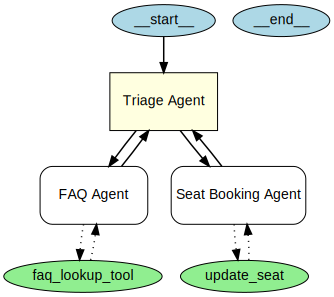

In [104]:
! pip install -Uq "openai-agents[viz]"

from agents.extensions.visualization import draw_graph

draw_graph(triage_agent)

## Run the Agent system

Be sure to create a session ID to maintain memory.

In [105]:
import uuid
from agents import SQLiteSession, Runner

session_id = str(uuid.uuid4())
session = SQLiteSession(session_id)

agent: Agent[AirlineAgentContext] = triage_agent
context = AirlineAgentContext(
    flight_number="FLT-123",
    seat_number="A12",
    passenger_name="John Doe",
)

result = await Runner.run(
    agent,
    input="can i change my seat?",
    session=session,
    context=context,
)

print(result.final_output)




I can help you change your seat. Could you please provide your confirmation number?
